# Flux of Mn across boundaries

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date
import seaborn as sns; sns.set()
import pandas as pd
import os

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax-imin
jsize = jmax-jmin

# model result set:
results_folder1 = '/data/brogalla/run_storage/Mn-set4-202004/'
results_folder2 = '/data/brogalla/run_storage/Mn-set5-202008/'

# Colors:
dirty  = '#90a1b1'
clean  = '#cee7fd'
rivers = '#519e98'
colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']

In [4]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, \
         2016, 2017, 2018, 2019]

###### Load files:

In [5]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

mesh      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12-EXH006_y2015m01d05_gridT.nc')
lons      = np.array(mesh.variables['nav_lon'])
lats      = np.array(mesh.variables['nav_lat'])

##### Functions:

In [6]:
def time_series_pickle(year, nosed=False, rivers=False):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # Load calculated time series of fluxes:
    if nosed:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(folder+'nosed-202005/'+'time-series-'+str(year)+'.pickle','rb'))  
    elif rivers:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(folder+'Mn-set5-202008/'+'time-series-'+str(year)+'.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
                pickle.load(open(folder+'Mn-set4-202004/'+'time-series-'+str(year)+'.pickle','rb'))
    
#     # Conservation of volume check:
#     sum_V = -1*np.sum(time_series_V1,axis=2) - np.sum(time_series_V2,axis=2) - np.sum(time_series_V7,axis=2) - \
#            (np.sum(time_series_V3,axis=2) + np.sum(time_series_V4,axis=2) + np.sum(time_series_V5,axis=2) + \
#             np.sum(time_series_V6,axis=2)) + np.sum(time_series_V8,axis=2) + np.sum(time_series_V9,axis=2)
# #     print('Total volume change at end of time period: ', np.sum(sum_V))

    # Into Parry Channel:   time_series_mn2    
    # Out of Parry Channel: time_series_mn11
    
    return time_series_mn2, time_series_mn11

In [7]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1 = np.sort(os.listdir(results_folder1+'ref-'+str(year)+'/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

#### Calculations:

In [8]:
exp1_in  = np.empty((len(years),72,50,79)); exp1_out = np.empty((len(years),72,50,52)); # ref
exp2_in  = np.empty((len(years),72,50,79)); exp2_out = np.empty((len(years),72,50,52)); # nosed
exp3_in  = np.empty((len(years),72,50,79)); exp3_out = np.empty((len(years),72,50,52)); # rivers

i=0
for year in years:
    ts_in1, ts_out1 = time_series_pickle(year)
    ts_in2, ts_out2 = time_series_pickle(year, nosed=True)
    ts_in3, ts_out3 = time_series_pickle(year, rivers=True)
    
    exp1_in[i,:,:,:]  = ts_in1
    exp2_in[i,:,:,:]  = ts_in2
    exp3_in[i,:,:,:]  = ts_in3
    exp1_out[i,:,:,:] = ts_out1
    exp2_out[i,:,:,:] = ts_out2
    exp3_out[i,:,:,:] = ts_out3
    
    i+=1

In [9]:
dates_2002 = file_dates(2002); dates_2003 = file_dates(2003); dates_2004 = file_dates(2004);
dates_2005 = file_dates(2005); dates_2006 = file_dates(2006); dates_2007 = file_dates(2007);
dates_2008 = file_dates(2008); dates_2009 = file_dates(2009); dates_2010 = file_dates(2010);
dates_2011 = file_dates(2011); dates_2012 = file_dates(2012); dates_2013 = file_dates(2013);
dates_2014 = file_dates(2014); dates_2015 = file_dates(2015); dates_2016 = file_dates(2016);
dates_2017 = file_dates(2017) ;dates_2018 = file_dates(2018); dates_2019 = file_dates(2019);

dates = np.array(dates_2002 + dates_2003 + dates_2004 + dates_2005 + dates_2006 + dates_2007 + dates_2008 + \
                 dates_2009 + dates_2010 + dates_2011 + dates_2012+ dates_2013 + dates_2014 + dates_2015 + \
                 dates_2016 + dates_2017 + dates_2018 + dates_2019)

In [10]:
Parry_ref_cumsumin  = np.cumsum(np.sum(-1*exp1_in, axis=(2,3)).flatten())
Parry_ref_cumsumout = np.cumsum(np.sum(-1*exp1_out, axis=(2,3)).flatten())

Parry_ref_in  = np.sum(-1*exp1_in, axis=(2,3)).flatten()
Parry_ref_out = np.sum(-1*exp1_out, axis=(2,3)).flatten()

Parry_ref_diff = Parry_ref_out - Parry_ref_in

In [11]:
Parry_nosed_cumsumin  = np.cumsum(np.sum(-1*exp2_in, axis=(2,3)).flatten())
Parry_nosed_cumsumout = np.cumsum(np.sum(-1*exp2_out, axis=(2,3)).flatten())

Parry_nosed_in  = np.sum(-1*exp2_in, axis=(2,3)).flatten()
Parry_nosed_out = np.sum(-1*exp2_out, axis=(2,3)).flatten()

Parry_nosed_diff = Parry_nosed_out - Parry_nosed_in

In [12]:
Parry_rivers_cumsumin  = np.cumsum(np.sum(-1*exp3_in, axis=(2,3)).flatten())
Parry_rivers_cumsumout = np.cumsum(np.sum(-1*exp3_out, axis=(2,3)).flatten())

Parry_rivers_in  = np.sum(-1*exp3_in, axis=(2,3)).flatten()
Parry_rivers_out = np.sum(-1*exp3_out, axis=(2,3)).flatten()

Parry_rivers_diff = Parry_rivers_out - Parry_rivers_in

### Figures

<IPython.core.display.Javascript object>


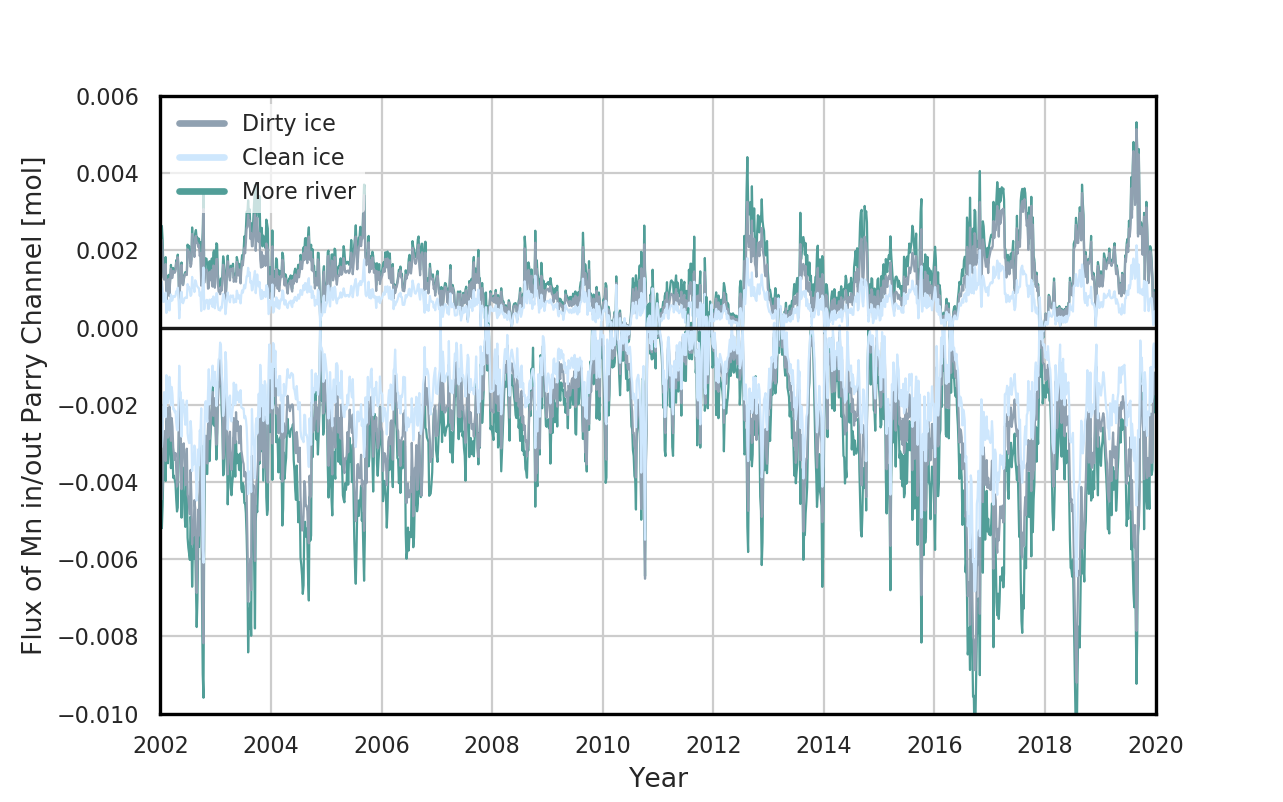

/home/brogalla/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/home/brogalla/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


In [19]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates,      Parry_rivers_in,    linewidth=1.0, color=rivers, markersize=7)
    sns.lineplot(dates, Parry_ref_in,       linewidth=1.0, color=dirty)
    sns.lineplot(dates,      Parry_nosed_in,     linewidth=1.0, color=clean, markersize=7)
    sns.lineplot(dates,      -1*Parry_rivers_out, linewidth=1.0, color=rivers)
    sns.lineplot(dates,      -1*Parry_ref_out,   linewidth=1.0, color=dirty)
    sns.lineplot(dates,      -1*Parry_nosed_out, linewidth=1.0, color=clean)
    
    sns.lineplot([0],[0], linewidth=3, color=dirty, label=r'Dirty ice')
    sns.lineplot([0],[0], linewidth=3, color=clean, label=r'Clean ice')
    sns.lineplot([0],[0], linewidth=3, color=rivers, label=r'More river')

    sns.lineplot([dt.datetime(2002,1,1), dt.datetime(2020,1,1)], [0,0], c='k')
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Flux of Mn in/out Parry Channel [mol]',fontsize=12)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.01, 0.006))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    font = matplotlib.font_manager.FontProperties(family='Helvetica', size=10)
    leg = ax.legend(loc=(0.01, 0.81), frameon=True, framealpha=0.7, prop=font)
    leg.get_frame().set_linewidth(0.0)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1/A4-flux-timeseries.png', bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1/A4-flux-timeseries.svg', bbox_inches='tight', dpi=300, \
            format='svg')

<IPython.core.display.Javascript object>


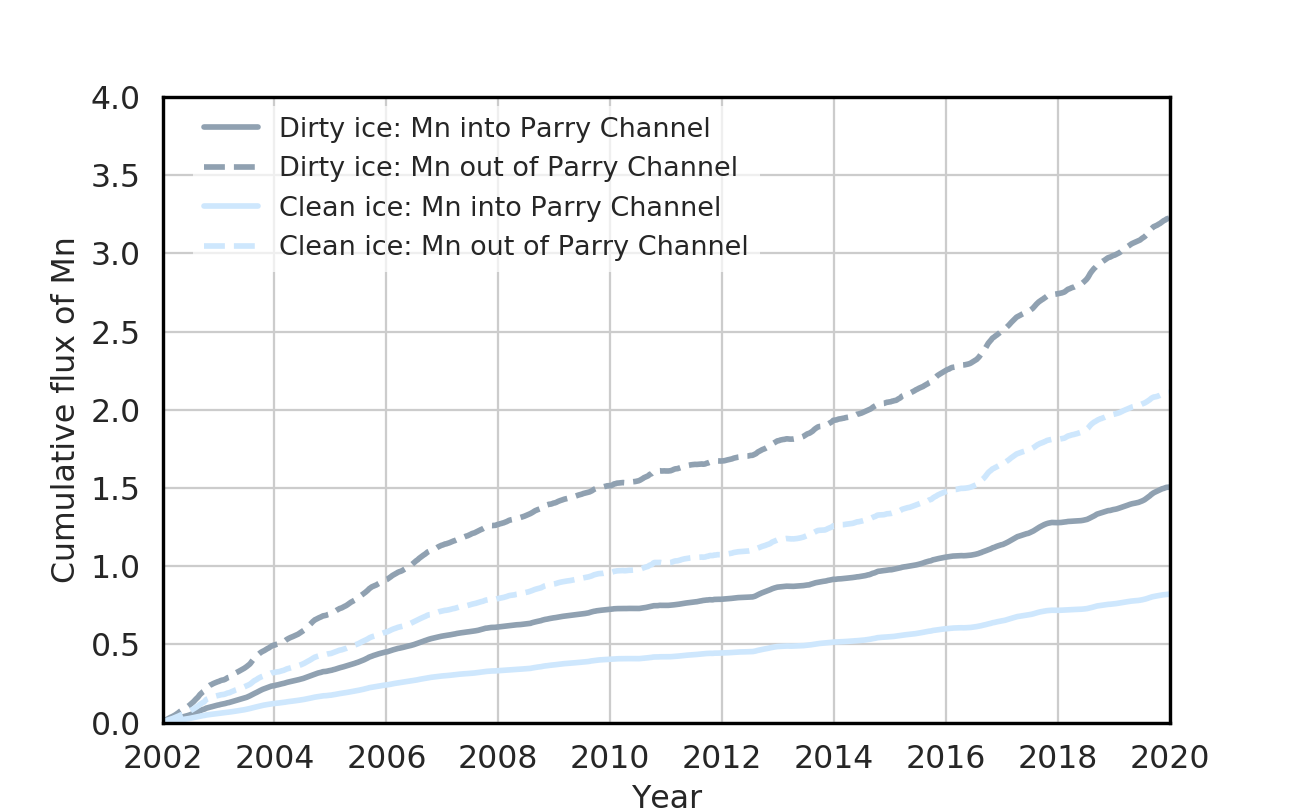

In [15]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_ref_cumsumin, linewidth=2.5, color=dirty, \
                      label=r'Dirty ice: Mn into Parry Channel')
    sns.lineplot(dates, Parry_ref_cumsumout, linewidth=2.5, color=dirty, \
                 label=r'Dirty ice: Mn out of Parry Channel')
    ax.lines[1].set_linestyle('--')
    
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], Parry_nosed_cumsumin, linewidth=2.5, color=clean, \
                 label=r'Clean ice: Mn into Parry Channel')
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], Parry_nosed_cumsumout, linewidth=2.5, color=clean, \
                 label=r'Clean ice: Mn out of Parry Channel')
    ax.lines[3].set_linestyle('--')
    
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Cumulative flux of Mn',fontsize=14)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 4.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    leg = ax.legend(loc=(0.03, 0.72), frameon=True, framealpha=0.7, fontsize=12)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/D2-Mn-flux-'+ \
#             str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

<IPython.core.display.Javascript object>


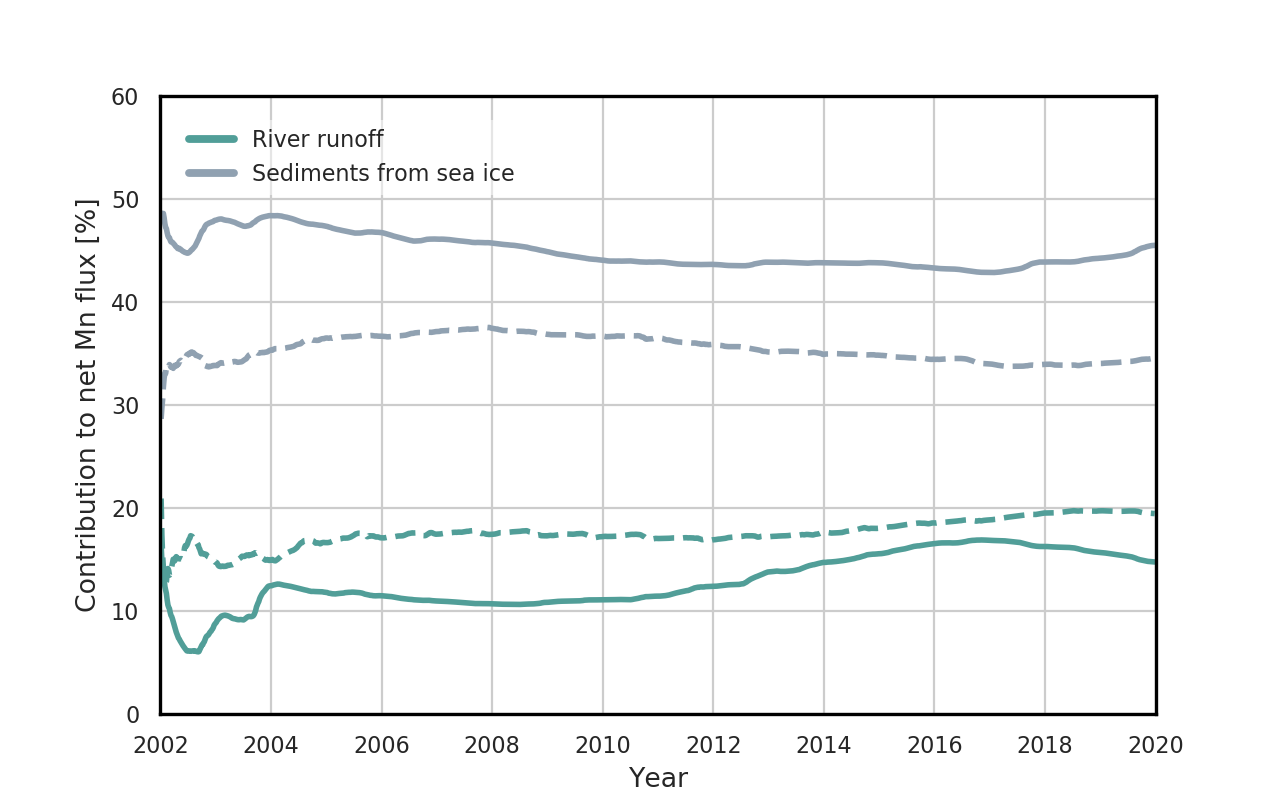

In [27]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

# Colors:
dirty  = '#90a1b1'
clean  = '#cee7fd'

with st:
    ax = sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                      (1-np.divide(Parry_nosed_cumsumin, Parry_ref_cumsumin[0:Parry_nosed_in.shape[0]]))*100, \
                      linewidth=2.5, color=dirty)
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                 (1-np.divide(Parry_nosed_cumsumout, Parry_ref_cumsumout[0:Parry_nosed_in.shape[0]]))*100, \
                 linewidth=2.5, color=dirty)
    sns.lineplot(dates[0:Parry_ref_in.shape[0]], \
                      (1-np.divide(Parry_ref_cumsumin, Parry_rivers_cumsumin[0:Parry_ref_in.shape[0]]))*100, \
                      linewidth=2.5, color=rivers)
    sns.lineplot(dates[0:Parry_ref_in.shape[0]], \
                 (1-np.divide(Parry_ref_cumsumout, Parry_rivers_cumsumout[0:Parry_ref_in.shape[0]]))*100, \
                 linewidth=2.5, color=rivers)
    ax.lines[1].set_linestyle('--')
    ax.lines[3].set_linestyle('--')
    
    sns.lineplot([0,0], [0,0], linewidth=3.5, color=rivers, label='River runoff')
    sns.lineplot([0,0], [0,0], linewidth=3.5, color=dirty, label='Sediments from sea ice')
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Contribution to net Mn flux [%]',fontsize=12)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 60))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black'); 

#     ax2 = ax.twinx()
#     ax2.grid(False)
#     ax2.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 60))
#     ax2.set_ylabel('Contribution to net Mn flux [%]',fontsize=14, color=rivers)#, labelpad=-520)
#     ax2.tick_params(axis='both', which='major', labelsize=0)
#     ax2.spines['left'].set_linewidth(1.5);   ax2.spines['left'].set_color('black');
#     ax2.spines['bottom'].set_linewidth(1.5); ax2.spines['bottom'].set_color('black');
#     ax2.spines['right'].set_linewidth(1.5);  ax2.spines['right'].set_color('black');
#     ax2.spines['top'].set_linewidth(1.5);    ax2.spines['top'].set_color('black'); 
    
    font = matplotlib.font_manager.FontProperties(family='Helvetica', size=10)
    leg = ax.legend(loc=(0.02, 0.84), frameon=True, framealpha=0.5, prop=font)
    leg.get_frame().set_linewidth(0.0)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1/A5-flux-percentage.png', bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1/A5-flux-percentage.svg', bbox_inches='tight', dpi=300, \
            format='svg')

<IPython.core.display.Javascript object>


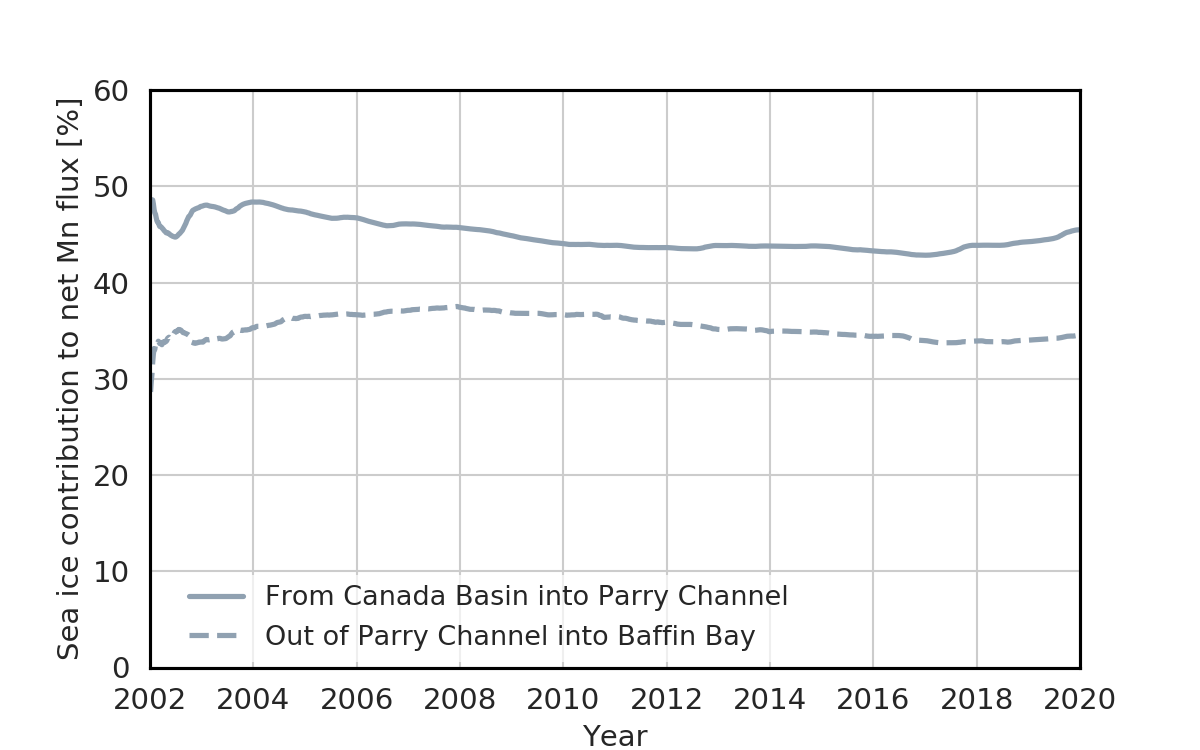

/home/brogalla/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [13]:
st  = sns.axes_style("whitegrid")

# Colors:
dirty  = '#90a1b1'
clean  = '#cee7fd'

with st:
    fig = plt.figure(figsize=(8,5))

    ax = sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                      (1-np.divide(Parry_nosed_cumsumin, Parry_ref_cumsumin[0:Parry_nosed_in.shape[0]]))*100, \
                      linewidth=2.5, color=dirty, label=r'From Canada Basin into Parry Channel')
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                 (1-np.divide(Parry_nosed_cumsumout, Parry_ref_cumsumout[0:Parry_nosed_in.shape[0]]))*100, \
                 linewidth=2.5, color=dirty, label=r'Out of Parry Channel into Baffin Bay')
    ax.lines[1].set_linestyle('--')
    
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Sea ice contribution to net Mn flux [%]',fontsize=14)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 60))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    leg = ax.legend(loc=(0.03, 0.01), frameon=True, framealpha=0.7, fontsize=13)
    leg.get_frame().set_linewidth(0.0)
 
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/A9-flux-percentage.png', bbox_inches='tight', dpi=300)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/D2-Mn-flux-percentage-'+ \
#             str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

<IPython.core.display.Javascript object>


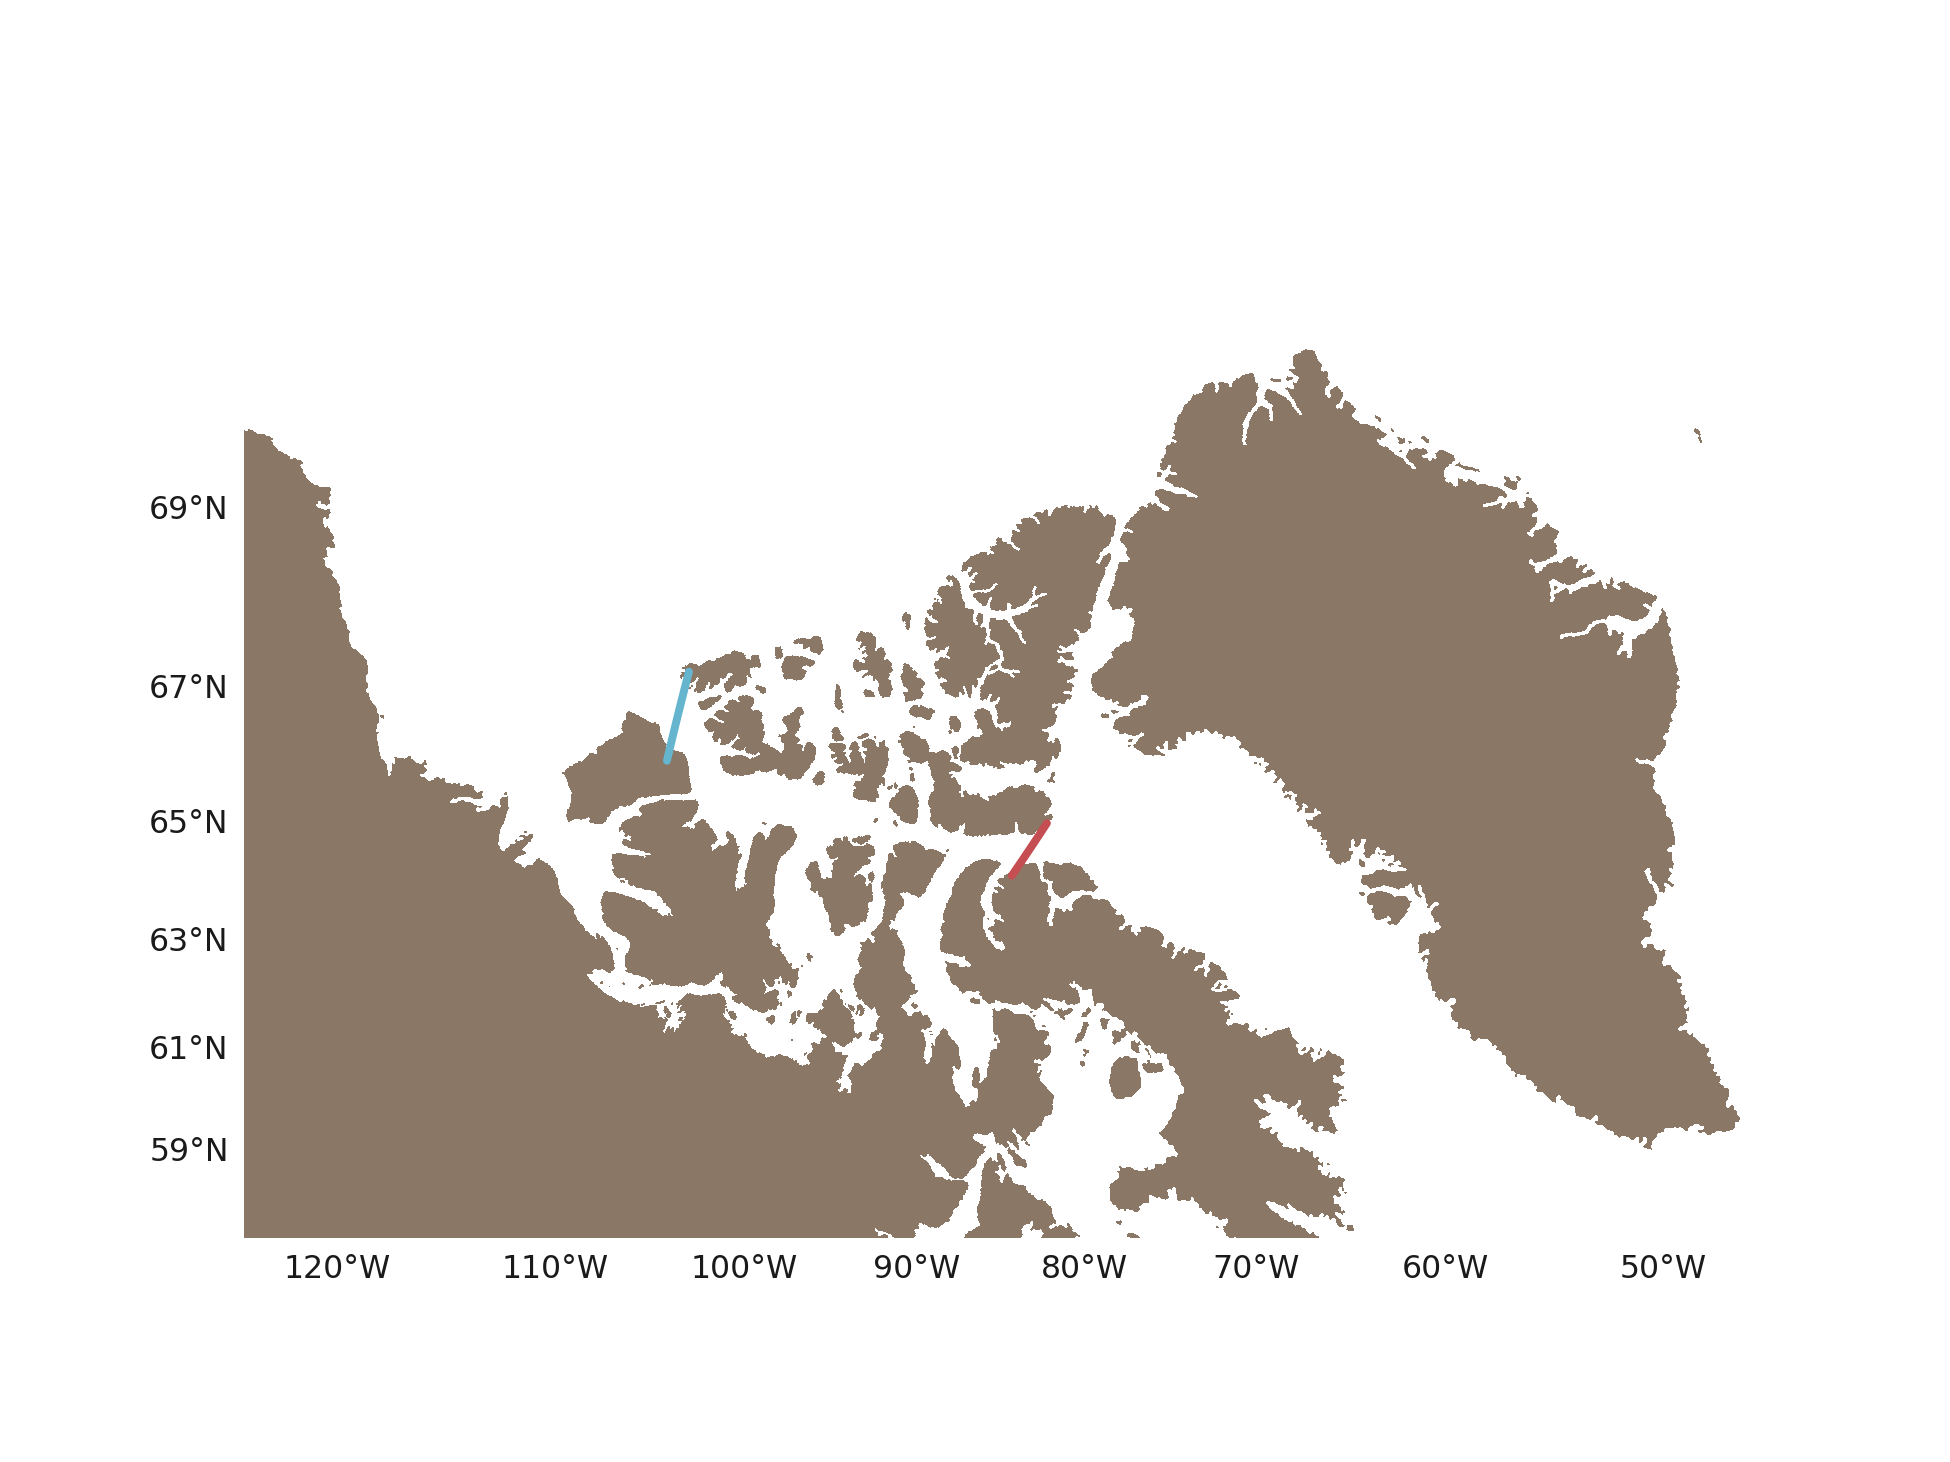

In [35]:
fig, ax1, proj1  = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

x_model, y_model = proj1(lons, lats)

proj1.plot(x_model[1935,450:530], y_model[1935,450:530], '-c', linewidth=3.5)
proj1.plot(x_model[1585,485:538], y_model[1585,485:538], '-r', linewidth=3.5)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/A5-Mn-flux-boundary-'+ \
            str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)